In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import h5py
import argparse
import os
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def evaluate_sine_series(coefs, X, Y):
    """
    Evaluate the 2D sine series on a 2D uniform grid.

    Parameters:
    coefs (2D array): Coefficients of the sine series.
    X (2D array): X coordinates of the grid.
    Y (2D array): Y coordinates of the grid.

    Returns:
    q (2D array): The evaluated sine series on the grid.
    """
    q = np.zeros_like(X)
    m, n = coefs.shape

    for j in range(m):
        for k in range(n):
            q += (
                coefs[j, k]
                * np.sin((j + 1) * (X + np.pi / 2))
                * np.sin((k + 1) * (Y + np.pi / 2))
            )

    return q

def sine_series(q: np.ndarray, X: np.ndarray, Y: np.ndarray, N: int):
    """
    Compute the coefficients of the 2D sine series given a signal q on a grid.

    Parameters:
    q (2D array): The signal on the grid.
    X (2D array): X coordinates of the grid.
    Y (2D array): Y coordinates of the grid.
    N (int): The size of the coefficient array (NxN).

    Returns:
    coefs (2D array): Coefficients of the sine series.
    """
    coefs = np.zeros((N, N))
    Mx, My = X.shape

    for j in range(N):
        for k in range(N):
            # Calculate the inner product <q, sin(j(x+pi/2))sin(k(y+pi/2))>
            sin_jx = np.sin((j + 1) * (X + np.pi / 2))
            sin_ky = np.sin((k + 1) * (Y + np.pi / 2))
            inner_product = np.sum(q * sin_jx * sin_ky)

            # Normalize the coefficient
            coefs[j, k] = (4 / (Mx * My)) * inner_product

    return coefs


In [3]:
def load_field_in_hdf5(
    key: str, fp_out: str, idx_slice=slice(None), retries: int = 0
) -> np.ndarray:
    """Loads an individual field to the specified field in a given hdf5 file"""
    if not os.path.exists(fp_out):
        raise FileNotFoundError("Can't load field %s from %s" % (key, fp_out))
    if retries >= 10:
        raise IOError(f"(lfih) Couldn't open file after 10 tries")
    try:
        with h5py.File(fp_out, "r") as hf:
            data_loaded = hf[key][()]
            data = data_loaded[idx_slice]

        return data

    except BlockingIOError:
        print("File is blocked; on retry # %i", retries)
        time.sleep(30)
        return load_field_in_hdf5(key, fp_out, idx_slice, retries + 1)


In [4]:
gt_fp = "/Users/owen/projects/recursive-linearization-code/data/2024-05-10_gd_testing/data_nu_8/measurements_0.h5"
q_gt = load_field_in_hdf5("q_cart", gt_fp)[4]

x_vals = np.linspace(-np.pi/2, np.pi/2, 192, endpoint=False)
(X, Y) = np.meshgrid(x_vals, x_vals)

print(q_gt.shape)
print(X.shape)
print(Y.shape)

(192, 192)
(192, 192)
(192, 192)


In [5]:
q_sine_series = sine_series(q_gt, X, Y, 96)

In [6]:
k_vals = np.linspace(1.0, 50.0, 10, endpoint=False)

In [8]:
rel_l2_error_lst = []
for k in k_vals:
    nmodes = int(2 * np.floor(k))
    q_trunc_sin = q_sine_series[:nmodes, :nmodes]
    q_trunc = evaluate_sine_series(q_trunc_sin, X, Y)
    rel_l2_error = np.linalg.norm(q_trunc - q_gt) / np.linalg.norm(q_gt)
    rel_l2_error_lst.append(rel_l2_error)
    print(f"Finished with k={k}")

    
    

In [9]:
rel_l2_error_arr = np.array(rel_l2_error_lst)


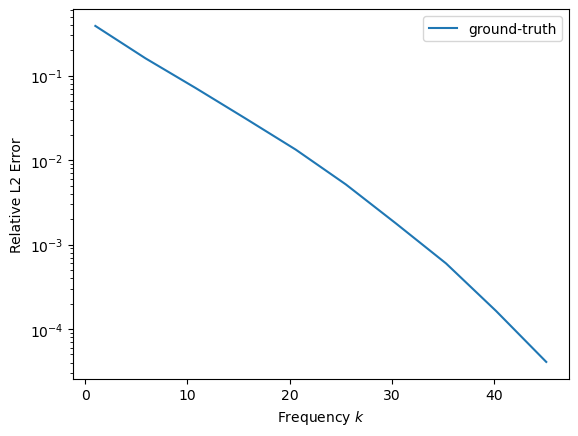

In [12]:
plt.plot(k_vals, rel_l2_error_arr, label='ground-truth')
plt.xlabel("Frequency $k$")
plt.ylabel("Relative L2 Error")
plt.yscale('log')
plt.legend()
plt.show()